In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
import pickle
from tableone import TableOne
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, average_precision_score, precision_recall_curve

In [2]:
# results2 = pd.read_csv('/local/scratch/zzaiman/CS334FinalProject/zach/runs/run1/results.csv')
results = pd.read_csv('/local/scratch/zzaiman/CS334FinalProject/zach/runs/run4/results_focal_loss.csv')
admissions = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/hosp/admissions.csv')
patients = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/hosp/patients.csv')


In [45]:
results2 = pd.read_csv('/local/scratch/zzaiman/CS334FinalProject/zach/runs/run1/results.csv')

In [3]:
admissions_demo = admissions.filter(['subject_id', 'race', 'language','insurance', 'marital_status', 'hospital_expire_flag'], axis=1)

In [43]:
admissions_demo_2 = admissions.filter(['subject_id', 'race', 'language','insurance', 'marital_status', 'hospital_expire_flag'], axis=1).drop_duplicates(subset='subject_id')

In [4]:
results = results.merge(admissions_demo, on='subject_id')
results = results.merge(patients, on='subject_id')
print(len(results.index))
results.head()

61571


,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,...,race,language,insurance,marital_status,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,WHITE,ENGLISH,Other,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04
1,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,OTHER,ENGLISH,Other,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04
2,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,WHITE,ENGLISH,Other,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04
3,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,WHITE,ENGLISH,Other,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04
4,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,OTHER,ENGLISH,Other,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04


In [46]:
results2 = results2.merge(admissions_demo_2, on='subject_id')
results2 = results2.merge(patients, on='subject_id')
print(len(results2.index))
results2.head()

5159


,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,...,race,language,insurance,marital_status,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10032725,50331901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,BLACK/AFRICAN AMERICAN,ENGLISH,Other,SINGLE,0,F,38,2143,2011 - 2013,2143-03-30
1,10032725,55504914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,BLACK/AFRICAN AMERICAN,ENGLISH,Other,SINGLE,0,F,38,2143,2011 - 2013,2143-03-30
2,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,WHITE,ENGLISH,Other,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04
3,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,WHITE,ENGLISH,Other,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04
4,10046166,51738740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,WHITE,ENGLISH,Other,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04


In [5]:
labels = 'Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices'.split(',')
labels = np.array(labels)

### Insurance

In [6]:
results['insurance'].value_counts()

Medicare    38485
Other       19488
Medicaid     3598
Name: insurance, dtype: int64

A patient's insurance provider can often overlap with the patient's socioeconomic status and/or age and therefore health outcomes. For example, low-income individuals are eligible to receive Medicaid, while patients who have Medicare as their insurance provider are either over 65 or have disabilitiess. "Other" refers to private insurance which is connected to active employment and/or higher income.

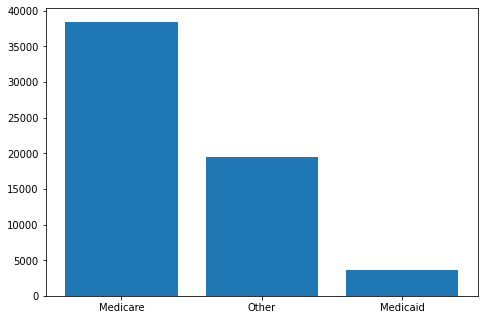

In [7]:
insurance_dist = results['insurance'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(insurance_dist.index, insurance_dist.values)
plt.show()

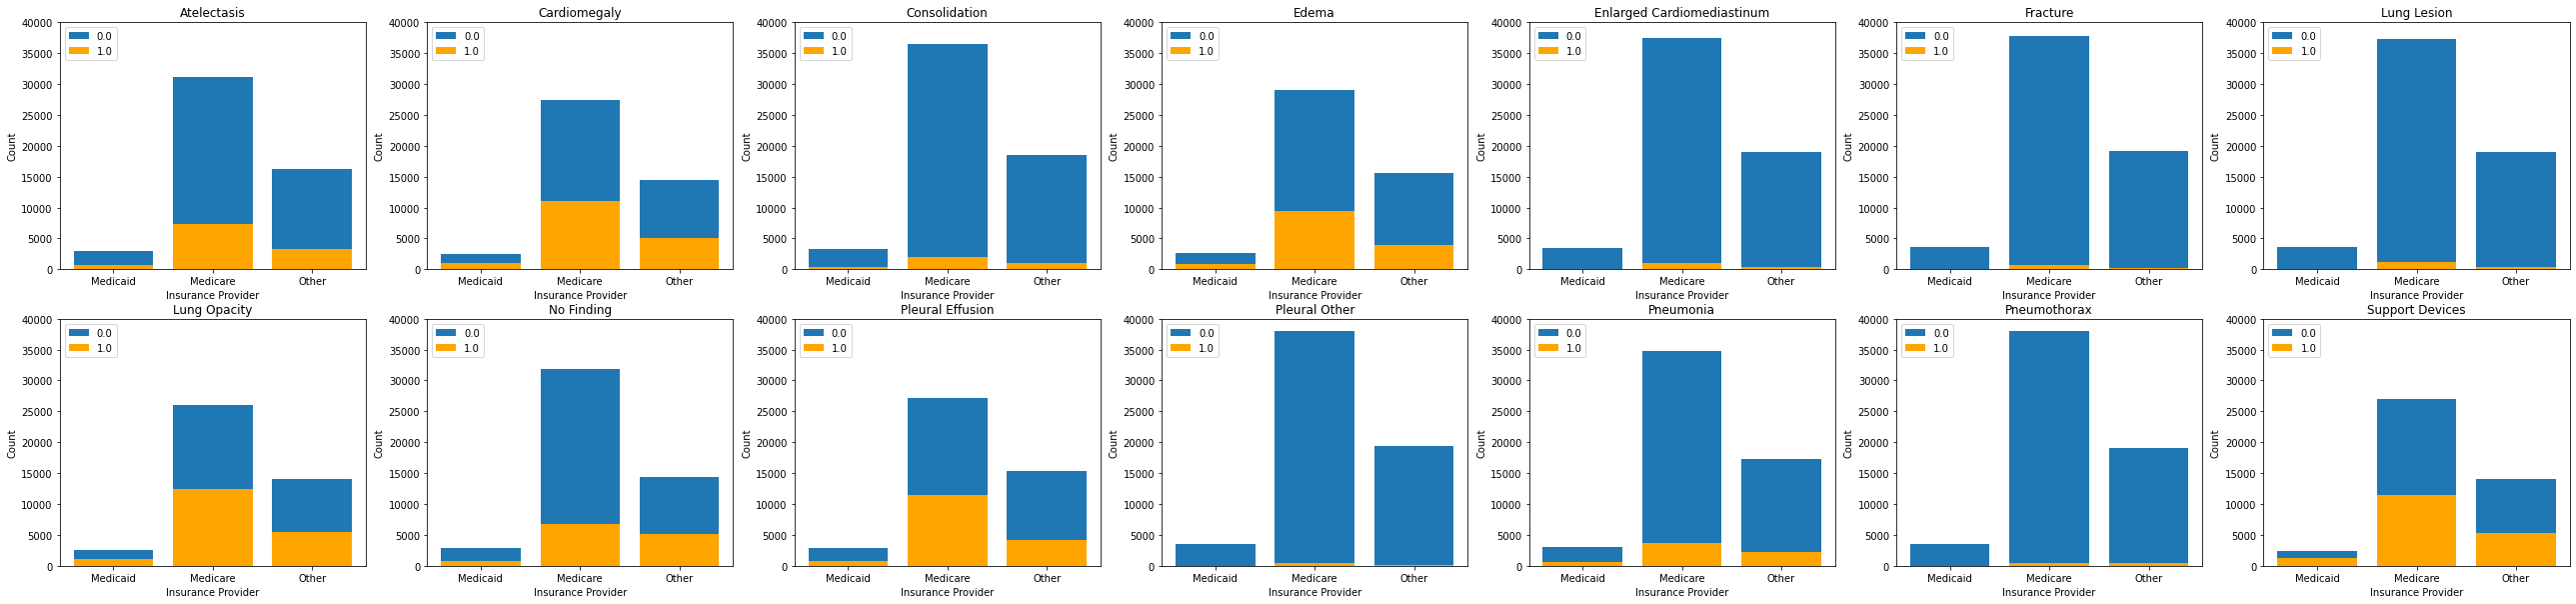

In [8]:
from matplotlib import ticker
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(45, 10))
insurance = ['Medicaid', 'Medicare', 'Other']
positions = [0,1,2]
for i, lab in enumerate(labels):
    if i < 7:
        x = 0
    else:
        x = 1
    if i < 7:
        y = i
    else:
        y = i - 7

    a = pd.DataFrame({'count': results.groupby([lab, 'insurance']).size()}).reset_index()
    neg_df = a[a[lab] == 0.0].iloc[:, 1:]
    pos_df = a[a[lab] == 1.0].iloc[:, 1:]
    ax[x,y].bar(neg_df.iloc[:,0], neg_df.iloc[:,1], label='0.0')
    ax[x,y].bar(pos_df.iloc[:,0], pos_df.iloc[:,1], color='orange', label='1.0')
    ax[x, y].title.set_text(lab)
    ax[x, y].legend(loc=2)
    ax[x, y].xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[x, y].xaxis.set_major_formatter(ticker.FixedFormatter(insurance))
    ax[x, y].set_xticklabels(insurance)
    ax[x, y].set_xlabel('Insurance Provider')
    ax[x, y].set_ylabel('Count')
    ax[x, y].set_ylim(0,40000)

_Initial observation: Medicaid people have a disproportionate number of support devices (more than half). Medicare people seem to disproportionately have Pleural Effusion (close to half)._

In [9]:
# Helper functions for evaluating model performance
# Generate 95% Confidence Intervals for each AUC score
def generate_CI(y_true, y_pred):

    n_bootstraps = 1000
    rng_seed = 2021  
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    #95% confidence interval
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    ci_str = '[{}, {}]'.format(str(round(confidence_lower, 3)), str(round(confidence_upper, 3)))
    return ci_str

# Calculate and plot ROC
def calc_roc(df, strata, labels):
    fpr = {}
    tpr = {}
    auc = {}
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7
        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])
        ci = generate_CI(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)} ci={ci}')
        for category in df[strata].unique():
            tmp = df[df[strata] == category].reset_index(drop=True)
            ytrue = tmp[lab]
            if len(np.unique(ytrue)) == 1:
                print(f"Dropped strata: {category} in class {lab}", flush=True)
                continue

            ypred = tmp['pred_'+lab]
            tfpr, ttpr, _ = roc_curve(ytrue, ypred)
            tauc = roc_auc_score(ytrue, ypred)
            fpr[str(category) + '_' + lab] = tfpr
            tpr[str(category) + '_' + lab] = ttpr
            auc[str(category) + '_' + lab] = tauc
            tci = generate_CI(ytrue, ypred)
            ax[x, y].plot(tfpr, ttpr, label=f'{str(category)} auc={round(tauc, 2)}, ci={tci}')
            ax[x, y].title.set_text(lab)
            ax[x, y].legend(loc = 4)
            
            ax[x, y].set_xlabel('FPR')
            ax[x, y].set_ylabel('TPR')

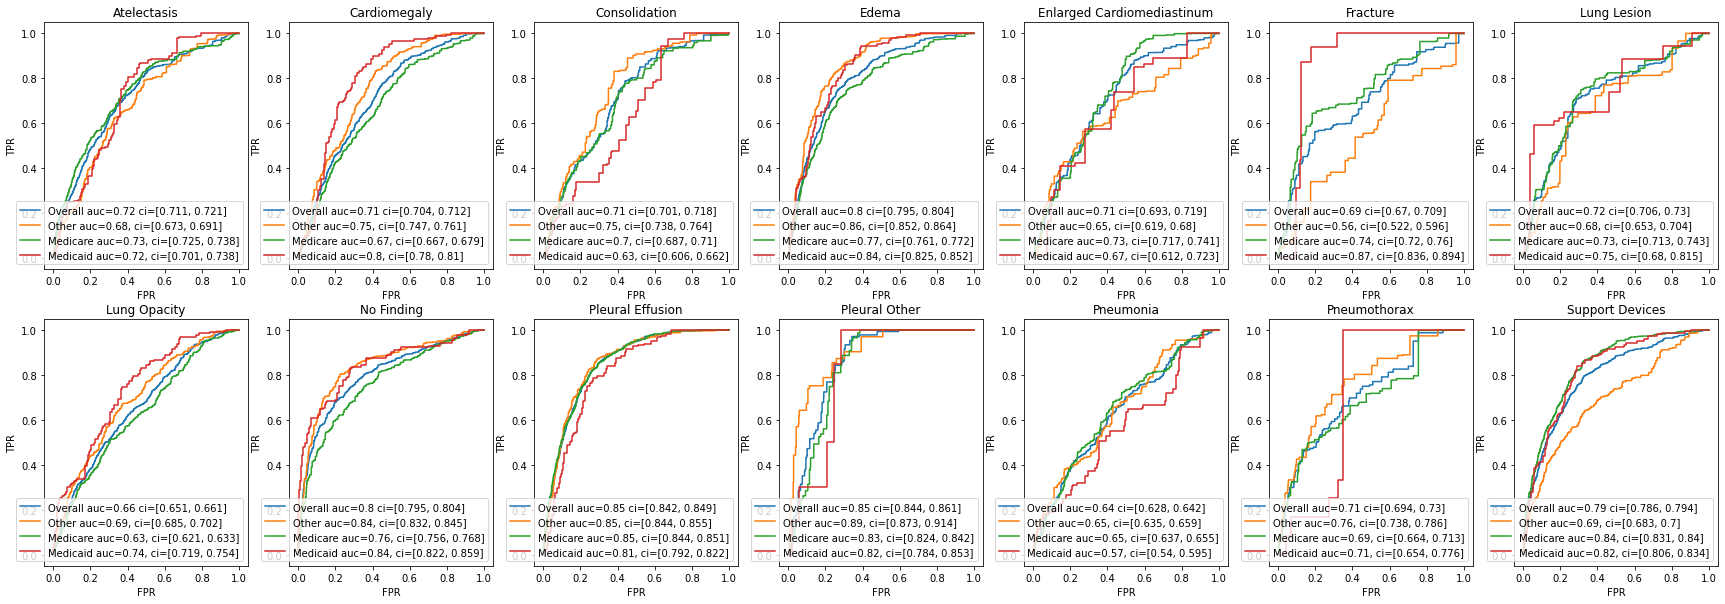

In [10]:
calc_roc(results, 'insurance', labels)

_Model performs noticeably worse for the "other" (i.e., privaye) insurance patients for the label of support devices._

We can use Pearson Correlation and/or Chi Square test to assess the correlation between a specific insurance provider and diagnosis

In [11]:
#Convert each insurance to a binary category
def isMedicare(x):
    if x['insurance'] == 'Medicare':
        return 1.0
    else: return 0.0

def isMedicaid(x):
    if x['insurance'] == 'Medicaid':
        return 1.0
    else: return 0.0

def isOther(x):
    if x['insurance'] != 'Medicare' and x['insurance'] != 'Medicaid':
        return 1.0
    else: return 0.0

In [12]:
insurance_df = results.copy()
insurance_df['isMedicare'] = insurance_df.apply(lambda row: isMedicare(row), axis=1)
insurance_df['isMedicaid'] = insurance_df.apply(lambda row: isMedicaid(row), axis=1)
insurance_df['isOther'] = insurance_df.apply(lambda row: isOther(row), axis=1)
insurance_df


,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,...,marital_status,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,isMedicare,isMedicaid,isOther
0,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04,0.0,0.0,1.0
1,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04,0.0,0.0,1.0
2,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04,0.0,0.0,1.0
3,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04,0.0,0.0,1.0
4,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,MARRIED,0,M,67,2132,2011 - 2013,2133-11-04,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61566,19991135,59381316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,SINGLE,0,F,57,2124,2008 - 2010,2133-07-19,1.0,0.0,0.0
61567,19991135,59381316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,DIVORCED,0,F,57,2124,2008 - 2010,2133-07-19,1.0,0.0,0.0
61568,19991135,59381316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,DIVORCED,0,F,57,2124,2008 - 2010,2133-07-19,1.0,0.0,0.0
61569,19991135,59381316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,DIVORCED,0,F,57,2124,2008 - 2010,2133-07-19,1.0,0.0,0.0


In [13]:
from scipy.stats import pearsonr

insurance_labels = ['isMedicare', 'isMedicaid', 'isOther']

insurance_corr_dict = dict()
for ins_lab in insurance_labels:
    ins_lab_dict = dict()

    for diag in labels:

        x = insurance_df[ins_lab]
        y = insurance_df[diag]

        corr, _ = pearsonr(x, y)
        ins_lab_dict[diag] = corr

    insurance_corr_dict[ins_lab] = dict(sorted(ins_lab_dict.items(), key=lambda item: item[1]))

insurance_corr_dict

{'isMedicare': {'No Finding': -0.09364022328104385,
  'Pneumonia': -0.03589912379690767,
  'Pneumothorax': -0.018886820661829583,
  'Consolidation': -0.012583172634471767,
  'Support Devices': 0.013077305063679646,
  'Enlarged Cardiomediastinum': 0.013402400314676521,
  'Fracture': 0.013543942645997797,
  'Pleural Other': 0.020787193636306264,
  'Atelectasis': 0.023909140584882353,
  'Cardiomegaly': 0.025292843286743385,
  'Lung Lesion': 0.029307967097529232,
  'Edema': 0.04543175118409233,
  'Lung Opacity': 0.04672877785259593,
  'Pleural Effusion': 0.09189330645622307},
 'isMedicaid': {'Pleural Effusion': -0.033720702321351444,
  'Pneumothorax': -0.022699561111376974,
  'Fracture': -0.022048574056317445,
  'Lung Lesion': -0.013982805452046193,
  'Lung Opacity': -0.008352805801175131,
  'Enlarged Cardiomediastinum': -0.007132221818745518,
  'No Finding': -0.003531377273741333,
  'Pleural Other': -0.0015190108340382069,
  'Atelectasis': 0.0040319594971854,
  'Cardiomegaly': 0.008383584

This does not return a strong correlation between any insurance provider and medical diagnosis. But let's plot in anyway.

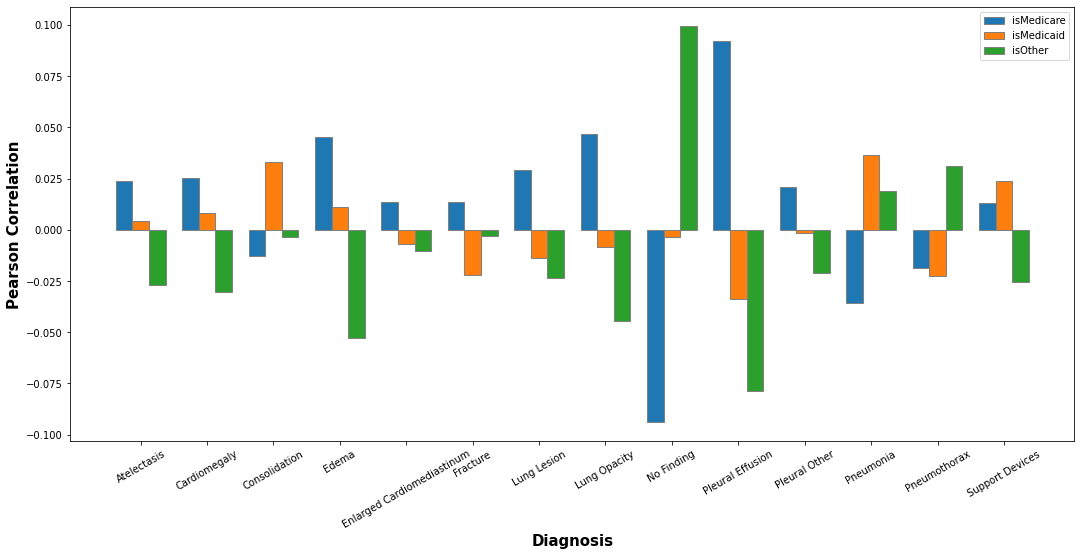

In [14]:
barWidth = 0.25
fig = plt.subplots(figsize =(18, 8))

lab_ins_corr_list = []

for i, ins in enumerate(insurance_corr_dict):

    correlations = []

    for diag in labels:

        correlations.append(insurance_corr_dict[ins][diag])
    
    lab_ins_corr_list.append(correlations)

    plt.bar(np.arange(i*barWidth, (i*barWidth)+len(labels)), correlations, width = barWidth, edgecolor ='grey', label=ins)

plt.xlabel('Diagnosis', fontweight ='bold', fontsize = 15)
plt.ylabel('Pearson Correlation', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(labels))], labels, rotation=30)
plt.legend()
plt.show()
    



Another approach to use with categorical data is using the chi square test.

In [15]:
from scipy.stats import chisquare

insurance_dist = results['insurance'].value_counts()
total_count = insurance_dist.sum()

chi_sq_dict = dict()
for lab in labels:
    lab_df = results[results[lab]==1.0]
    
    f_obs = [len(lab_df[lab_df['insurance']==insurance]) for insurance in insurance_dist.index]
    f_exp = [len(lab_df) * (insurance_dist[insurance]/total_count) for insurance in insurance_dist.index]

    chi_sq_dict[lab] = chisquare(f_obs, f_exp=f_exp)
        
chi_sq_dict

{'Atelectasis': Power_divergenceResult(statistic=36.42869453848371, pvalue=1.2291630304438813e-08),
 'Cardiomegaly': Power_divergenceResult(statistic=41.83403363711564, pvalue=8.238630357723486e-10),
 'Consolidation': Power_divergenceResult(statistic=64.01054159309103, pvalue=1.2597590913872235e-14),
 'Edema': Power_divergenceResult(statistic=132.04136402541153, pvalue=2.126092279335688e-29),
 'Enlarged Cardiomediastinum': Power_divergenceResult(statistic=11.319200079470164, pvalue=0.003483910045175998),
 'Fracture': Power_divergenceResult(statistic=32.28870457307368, pvalue=9.740850726423511e-08),
 'Lung Lesion': Power_divergenceResult(statistic=52.763242394930856, pvalue=3.4882490954025044e-12),
 'Lung Opacity': Power_divergenceResult(statistic=95.21297102428952, pvalue=2.112350779286636e-21),
 'No Finding': Power_divergenceResult(statistic=492.24916194905865, pvalue=1.2866268848670773e-107),
 'Pleural Effusion': Power_divergenceResult(statistic=383.26212787339955, pvalue=5.966042887

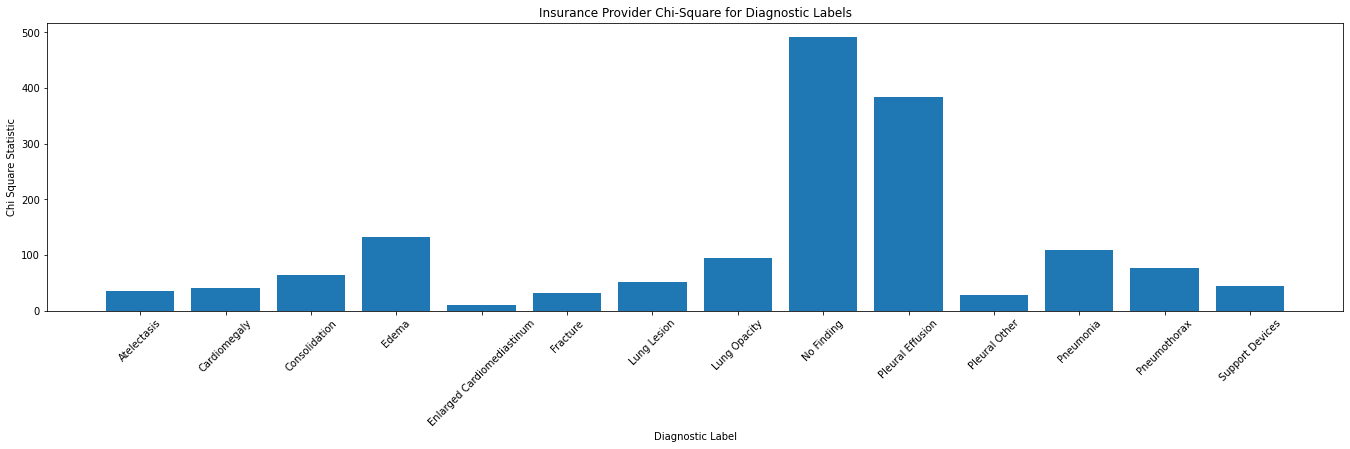

In [80]:
#remove labels that are not statistically significant
copy_dict = dict(chi_sq_dict)
for lab in chi_sq_dict:
    if copy_dict[lab][1] > 0.05: del copy_dict[lab]

#plot the rest
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
ax.bar([lab for lab in copy_dict], [copy_dict[lab][0] for lab in copy_dict])
plt.xticks(rotation=45)
plt.title("Insurance Provider Chi-Square for Diagnostic Labels")
plt.ylabel("Chi Square Statistic")
plt.xlabel("Diagnostic Label")
plt.show()

_Impression: All of the labels have a distributions (with regards to insurance) that is stastically significantly different from uniform distrubition. This is especially true for "No Finding" and "Pleural Effusion" labels, and to some extent the "Edema" label. We can compare this to the findings from the Pearson correlation test to make better sense of this non-uniform distribution. We see that Other (i.e., private) insurance provider is slighlty positively correlated with No Finding. A possible interpretation is that people with private health insurance are more likely to make hospital visits without a specific ilness, or they are more likely to get an x-ray once they are in the hospital. Medicare is slightly negatively correlated with No Finding, possibly because most Medicare beneficiaries are old and older people who are making a hospital visit are more likely to have at leat one of the conditions detected by our model._

### Age

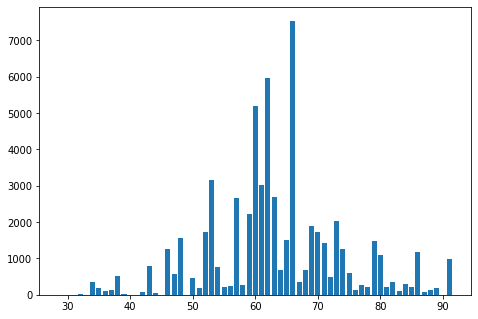

In [21]:
age_dist = results['anchor_age'].value_counts().sort_index()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(age_dist.index, age_dist.values)
plt.show()

Age can be correlated with many health outcomes. "Anchor age" provided in this dataset is not exact but roughly reflects (~2 years) the patient's age for the purpose of anonymization. All patients older than 89 years have 91 as their anchor age, which explains the relatively high incident of that age in the distribution. Since this is hospital patient data, the age distribution skews older, with the youngest recorded anchor age being 29.

In [22]:
def age_groups(x):
    if x['anchor_age'] < 30:
        return '20-29'
    if x['anchor_age'] < 40:
        return '30-39'
    if x['anchor_age'] < 50:
        return '40-49'
    if x['anchor_age'] < 60:
        return '50-59'
    if x['anchor_age'] < 70:
        return '60-69'
    if x['anchor_age'] < 80:
        return '70-79'
    if x['anchor_age'] < 90:
        return '80-89'
    else: return '90+'

results['age_cohort'] = results.apply(lambda row: age_groups(row), axis=1)
age_cohort_dist = results['age_cohort'].value_counts().sort_index()
    

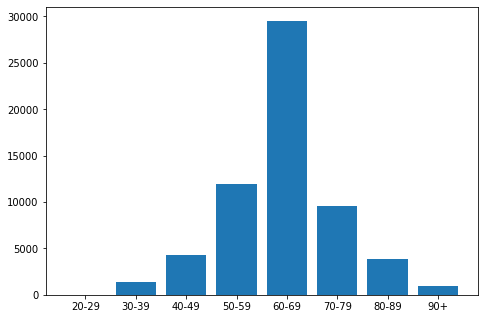

In [23]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(age_cohort_dist.index, age_cohort_dist.values)
plt.show()

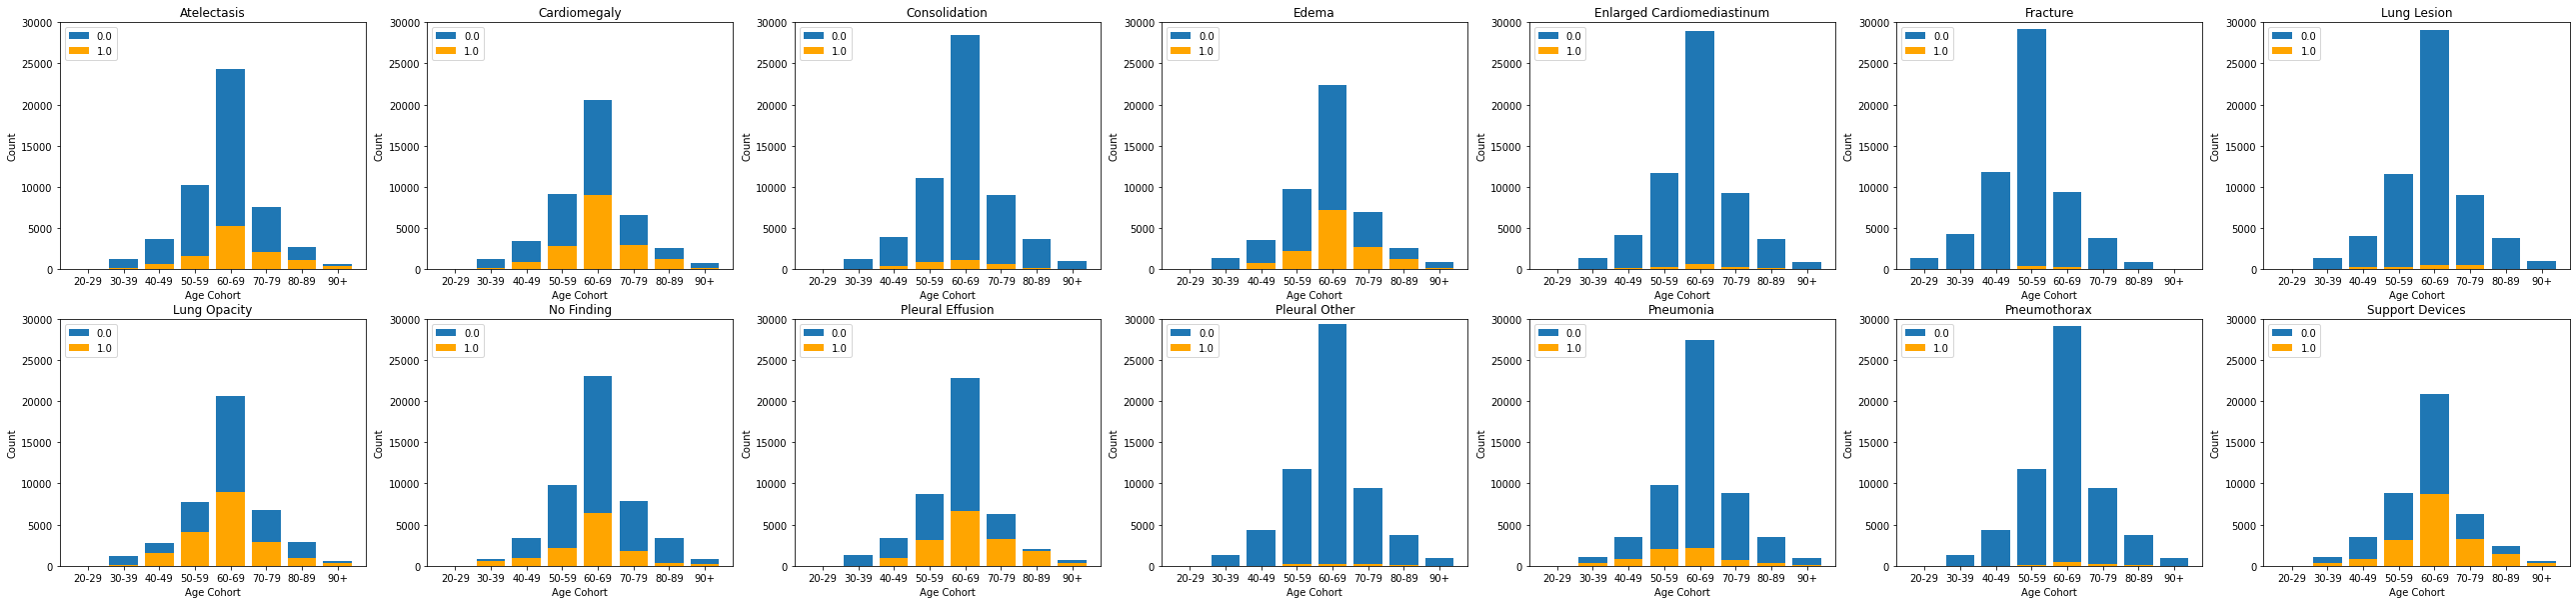

In [26]:
from matplotlib import ticker
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(45, 10))
cohort = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
positions = [0,1,2,3,4,5,6,7]
for i, lab in enumerate(labels):
    if i < 7:
        x = 0
    else:
        x = 1
    if i < 7:
        y = i
    else:
        y = i - 7

    a = pd.DataFrame({'count': results.groupby([lab, 'age_cohort']).size()}).reset_index()
    neg_df = a[a[lab] == 0.0].iloc[:, 1:]
    pos_df = a[a[lab] == 1.0].iloc[:, 1:]
    ax[x,y].bar(neg_df.iloc[:,0], neg_df.iloc[:,1], label='0.0')
    ax[x,y].bar(pos_df.iloc[:,0], pos_df.iloc[:,1], color='orange', label='1.0')
    ax[x, y].title.set_text(lab)
    ax[x, y].legend(loc=2)
    ax[x, y].xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[x, y].xaxis.set_major_formatter(ticker.FixedFormatter(cohort))
    ax[x, y].set_xticklabels(cohort)
    ax[x, y].set_xlabel('Age Cohort')
    ax[x, y].set_ylabel('Count')
    ax[x, y].set_ylim(0,30000)

_Initial observations: Labels "No Finding" and "Pneumonia" are disproportinately common for younger age cohorts. Pleural Effusion, Support Devices, and Atelectasis are disproportinately common for older age cohorts._

In [60]:
# Calculate and plot ROC
def calc_roc_age(df, strata, labels):
    fpr = {}
    tpr = {}
    auc = {}
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    hspace=0.97,
                    wspace=0.2)
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7
        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])
        ci = generate_CI(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)} ci={ci}')
        for category in df[strata].unique():
            tmp = df[df[strata] == category].reset_index(drop=True)
            ytrue = tmp[lab]
            if len(np.unique(ytrue)) == 1:
                print(f"Dropped strata: {category} in class {lab}", flush=True)
                continue

            ypred = tmp['pred_'+lab]
            tfpr, ttpr, _ = roc_curve(ytrue, ypred)
            tauc = roc_auc_score(ytrue, ypred)
            fpr[str(category) + '_' + lab] = tfpr
            tpr[str(category) + '_' + lab] = ttpr
            auc[str(category) + '_' + lab] = tauc
            tci = generate_CI(ytrue, ypred)
            ax[x, y].plot(tfpr, ttpr, label=f'{str(category)} auc={round(tauc, 2)}, ci={tci}')
            ax[x, y].title.set_text(lab)
            ax[x, y].legend(loc = 8, bbox_to_anchor=(0.5, -0.82))
            
            ax[x, y].set_xlabel('FPR')
            ax[x, y].set_ylabel('TPR')

Dropped strata: 20-29 in class Atelectasis
Dropped strata: 20-29 in class Cardiomegaly
Dropped strata: 20-29 in class Consolidation
Dropped strata: 20-29 in class Edema
Dropped strata: 20-29 in class Enlarged Cardiomediastinum
Dropped strata: 20-29 in class Fracture
Dropped strata: 20-29 in class Lung Lesion
Dropped strata: 20-29 in class Lung Opacity
Dropped strata: 20-29 in class No Finding
Dropped strata: 20-29 in class Pleural Effusion
Dropped strata: 90+ in class Pleural Other
Dropped strata: 30-39 in class Pleural Other
Dropped strata: 20-29 in class Pleural Other
Dropped strata: 20-29 in class Pneumonia
Dropped strata: 30-39 in class Pneumothorax
Dropped strata: 20-29 in class Pneumothorax
Dropped strata: 20-29 in class Support Devices


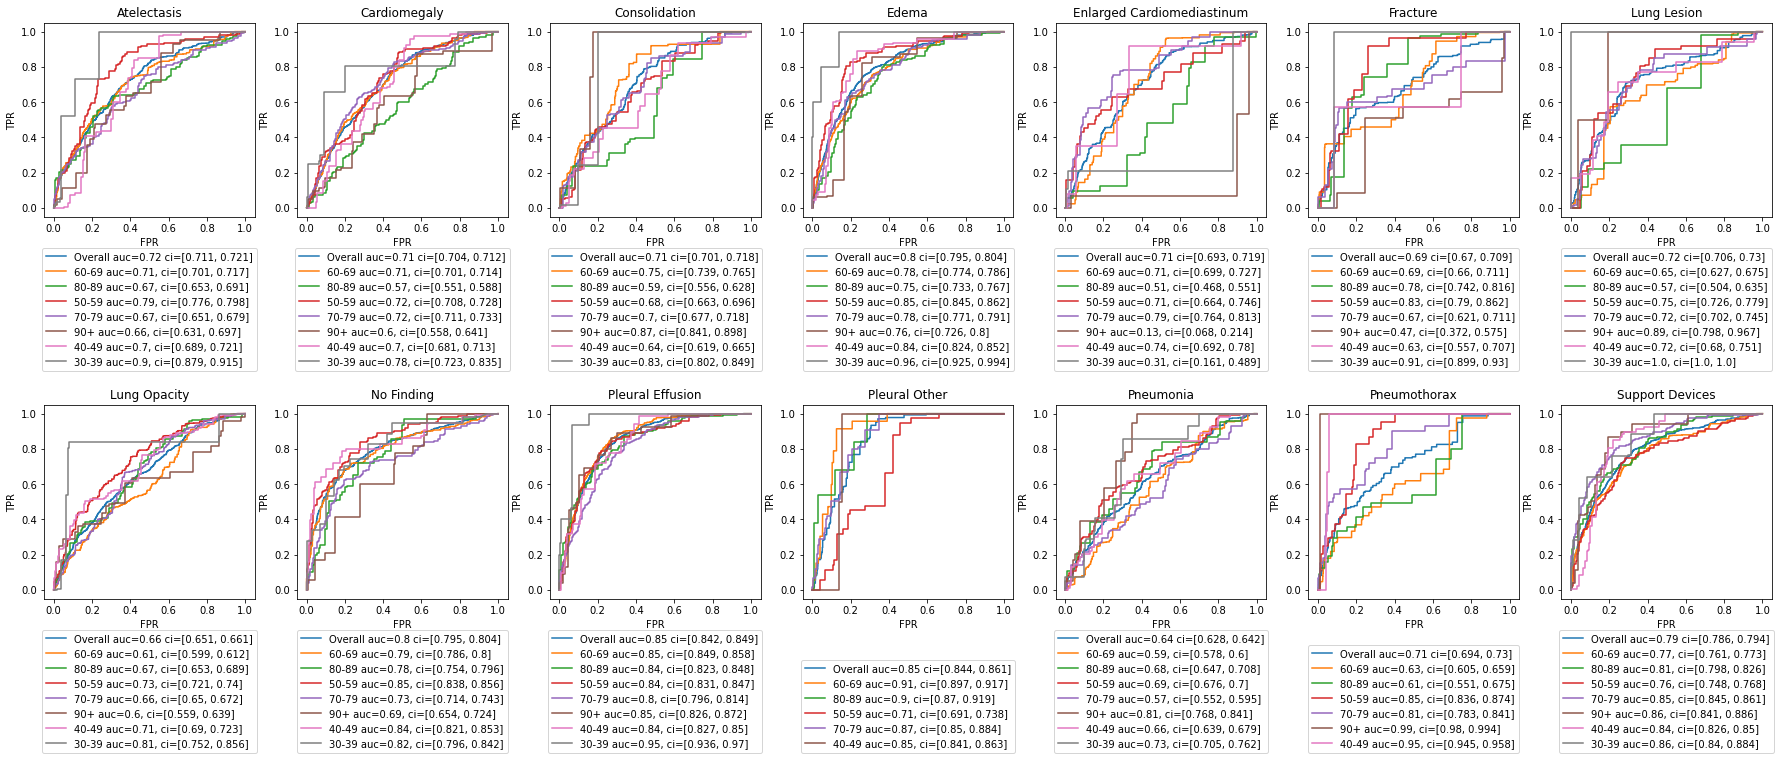

In [61]:
calc_roc_age(results, 'age_cohort', labels)

In [62]:
#Code to make cohorts of roughly equal size. There is probably a more elegant way of doing this. This way the last cohort always has fewer people.
def build_equal_cohorts(df, age_count, num_cohorts):

    total_size = len(df.index)
    
    cohort_size = total_size/num_cohorts

    curr_cohort_size = 0
    cohort_name = ''
    isNewCohort = True
    cohorts = []
    lower_bound = -1
    upper_bound = -1        
    for age, count in age_count.iteritems():
        if isNewCohort:
            cohort_name = str(age) + '-'
            lower_bound = age
            isNewCohort = False
        curr_cohort_size += count
    
        if curr_cohort_size > cohort_size:
            upper_bound = age
            cohort_name += str(age)
            cohorts.append((cohort_name, lower_bound, upper_bound))
            curr_cohort_size = 0
            isNewCohort = True

    if len(cohorts)<num_cohorts:
        cohort_name += str(age_dist.index[-1])
        cohorts.append((cohort_name , lower_bound, age_dist.index[-1]))
    
    return cohorts  

In [66]:
num_cohorts = 6
equal_age_dist = build_equal_cohorts(results, age_dist, num_cohorts)
equal_age_dist

[('29-53', 29, 53),
 ('54-60', 54, 60),
 ('61-63', 61, 63),
 ('64-68', 64, 68),
 ('69-79', 69, 79),
 ('80-91', 80, 91)]

In [67]:
def equal_age_groups(x, equal_age_dist):
    if x['anchor_age'] <= equal_age_dist[0][2]:
        return equal_age_dist[0][0]
    if x['anchor_age'] <= equal_age_dist[1][2]:
        return equal_age_dist[1][0]
    if x['anchor_age'] <= equal_age_dist[2][2]:
        return equal_age_dist[2][0]
    if x['anchor_age'] <= equal_age_dist[3][2]:
        return equal_age_dist[3][0]
    if x['anchor_age'] <= equal_age_dist[4][2]:
        return equal_age_dist[4][0]
    if x['anchor_age'] <= equal_age_dist[5][2]:
        return equal_age_dist[5][0]
    else: return equal_age_dist[6][0]


results_2 = results.copy()
results_2['age_cohort'] = results_2.apply(lambda row: equal_age_groups(row, equal_age_dist), axis=1)
equal_age_cohort_dist = results_2['age_cohort'].value_counts().sort_index()
equal_age_cohort_dist

29-53    11223
54-60    11546
61-63    11689
64-68    10795
69-79    11503
80-91     4815
Name: age_cohort, dtype: int64

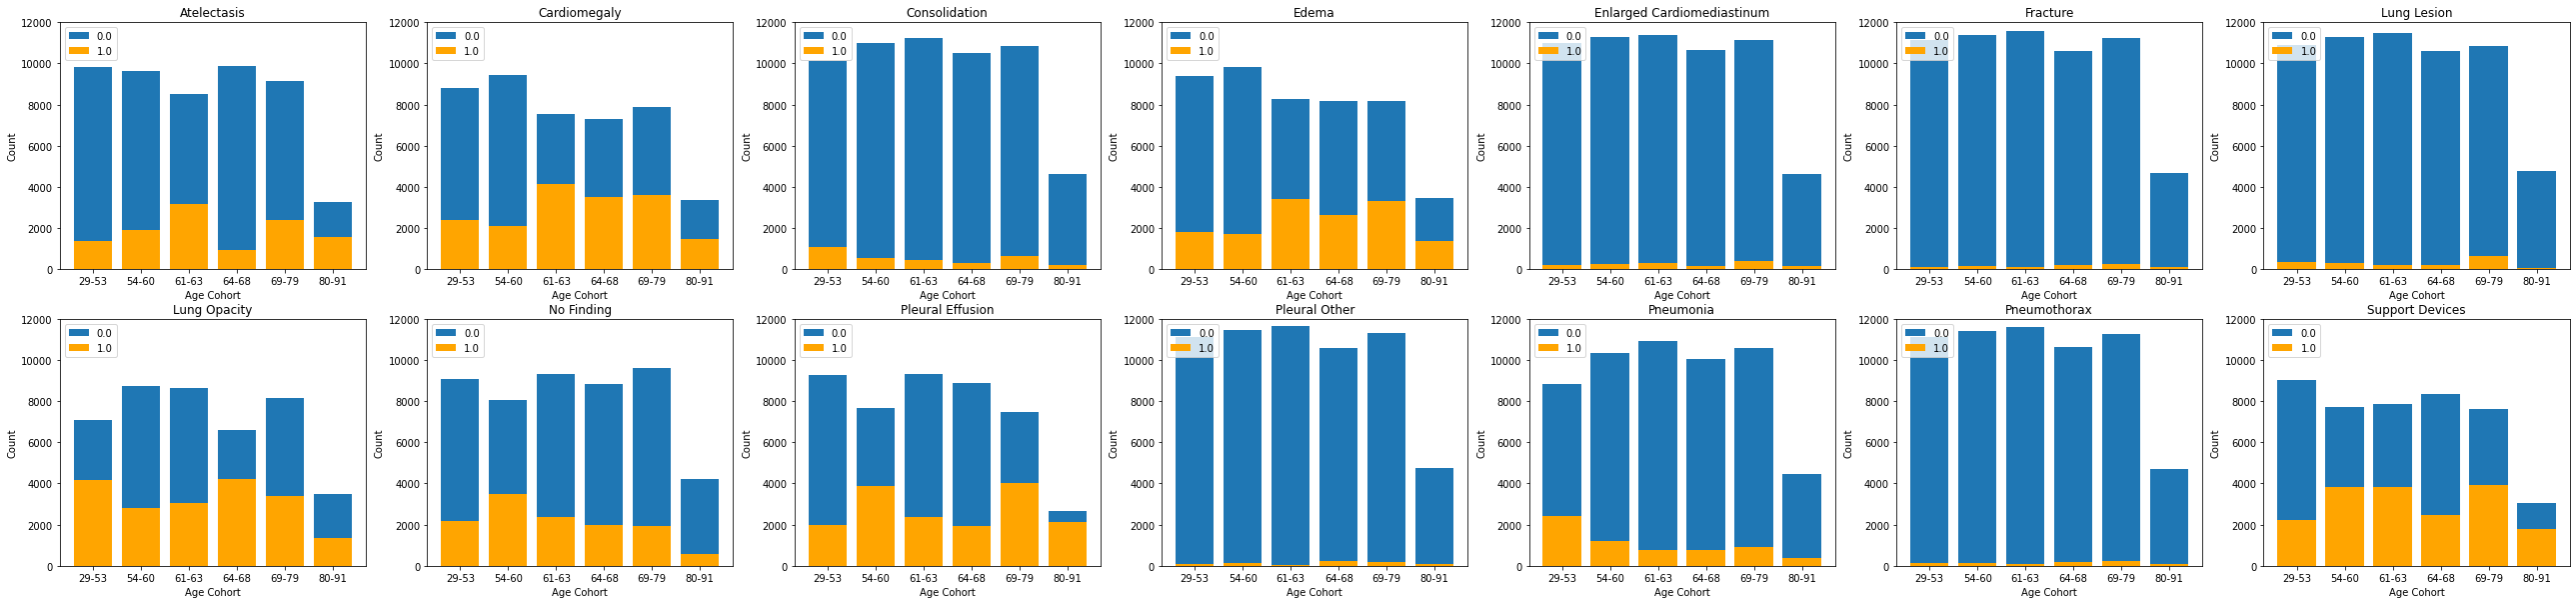

In [69]:
from matplotlib import ticker
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(45, 10))
cohorts = [x[0] for x in equal_age_dist]
# print(cohorts)
positions = [i for i in range(0, num_cohorts)]
# print(positions)
for i, lab in enumerate(labels):
    if i < 7:
        x = 0
    else:
        x = 1
    if i < 7:
        y = i
    else:
        y = i - 7

    a = pd.DataFrame({'count': results_2.groupby([lab, 'age_cohort']).size()}).reset_index()
    neg_df = a[a[lab] == 0.0].iloc[:, 1:]
    pos_df = a[a[lab] == 1.0].iloc[:, 1:]
    ax[x,y].bar(neg_df.iloc[:,0], neg_df.iloc[:,1], label='0.0')
    ax[x,y].bar(pos_df.iloc[:,0], pos_df.iloc[:,1], color='orange', label='1.0')
    ax[x, y].title.set_text(lab)
    ax[x, y].legend(loc=2)
    ax[x, y].xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[x, y].xaxis.set_major_formatter(ticker.FixedFormatter(cohorts))
    ax[x, y].set_xticklabels(cohorts)
    ax[x, y].set_xlabel('Age Cohort')
    ax[x, y].set_ylabel('Count')
    ax[x, y].set_ylim(0,12000)

_Initial observation: younger patients disproportionately have pneumonia._

We can also look at the roc scores. Equal cohort sizes might produce more interpretible results.

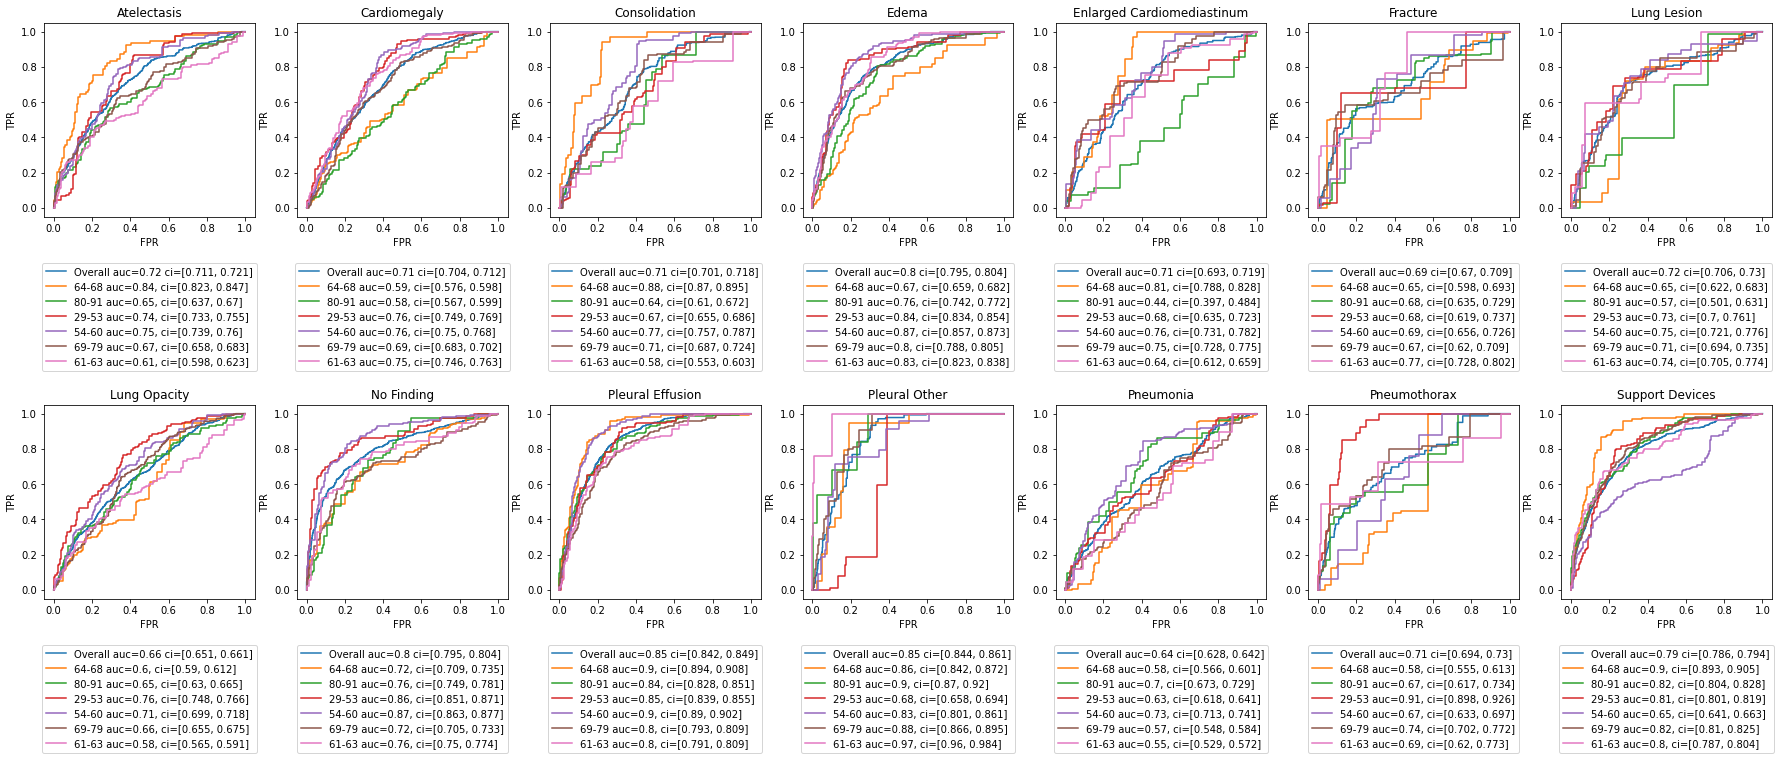

In [71]:
calc_roc_age(results_2, 'age_cohort', labels)

_Probably won't use equal-size age buckets_

In [72]:
from scipy.stats import pearsonr

corr_dict = dict()
for lab in labels:

    x = results['anchor_age']
    y = results[lab]

    corr, _ = pearsonr(x, y)
    corr_dict[lab] = corr


dict(sorted(corr_dict.items(), key=lambda item: item[1]))


{'Pneumonia': -0.11525708193210518,
 'No Finding': -0.08668444539762285,
 'Consolidation': -0.04954967055292716,
 'Lung Opacity': -5.0529643982947375e-05,
 'Lung Lesion': 0.005494454384952583,
 'Enlarged Cardiomediastinum': 0.028295837108580284,
 'Pleural Other': 0.033865834798639846,
 'Fracture': 0.03454419358458585,
 'Pneumothorax': 0.04112128855518286,
 'Cardiomegaly': 0.07763836354169257,
 'Support Devices': 0.08810918640014256,
 'Atelectasis': 0.09779763540875759,
 'Edema': 0.09853128237906877,
 'Pleural Effusion': 0.143455759151981}

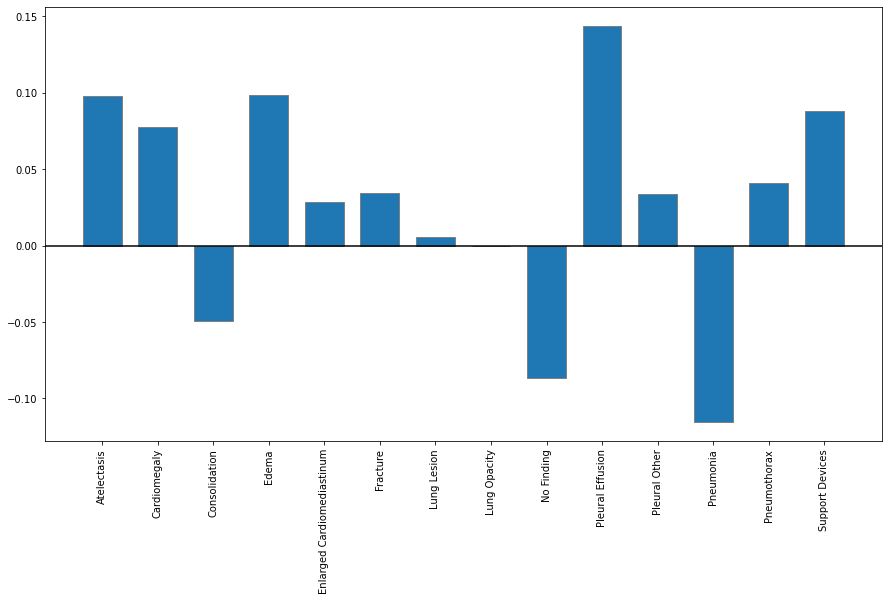

In [73]:
fig, ax = plt.subplots(figsize =(15, 8))
plt.axhline(y=0, c="black")
plt.bar(np.arange(0, len(corr_dict)*2, 2), corr_dict.values(), width=1.4, edgecolor ='grey')
plt.xticks(np.arange(0, len(corr_dict)*2, 2), corr_dict.keys(),
       rotation='vertical')
plt.show()

We can also use the chi-square test on the age buckets (I don't know if this is needed). 

In [75]:
from scipy.stats import chisquare

age_cohort_dist = results['age_cohort'].value_counts()
total_count = age_cohort_dist.sum()

chi_sq_age_dict = dict()
for lab in labels:
    lab_df = results[results[lab]==1.0]
    
    f_obs = [len(lab_df[lab_df['age_cohort']==age_cohort]) for age_cohort in age_cohort_dist.index]
    f_exp = [len(lab_df) * (age_cohort_dist[age_cohort]/total_count) for age_cohort in age_cohort_dist.index]

    chi_sq_age_dict[lab] = chisquare(f_obs, f_exp=f_exp)
        
chi_sq_age_dict

{'Atelectasis': Power_divergenceResult(statistic=779.3482503103855, pvalue=5.304487822576896e-164),
 'Cardiomegaly': Power_divergenceResult(statistic=505.25401565923454, pvalue=5.948531039260407e-105),
 'Consolidation': Power_divergenceResult(statistic=469.1454566194546, pvalue=3.4285422463734577e-97),
 'Edema': Power_divergenceResult(statistic=799.5770172460013, pvalue=2.289674747023382e-168),
 'Enlarged Cardiomediastinum': Power_divergenceResult(statistic=72.32535979886168, pvalue=5.000730447060516e-13),
 'Fracture': Power_divergenceResult(statistic=391.22582791484, pvalue=1.814955037289166e-80),
 'Lung Lesion': Power_divergenceResult(statistic=658.7758865091996, pvalue=5.3042694064090144e-138),
 'Lung Opacity': Power_divergenceResult(statistic=349.0046108399124, pvalue=2.0126535307766305e-71),
 'No Finding': Power_divergenceResult(statistic=667.5854340664936, pvalue=6.699400811264231e-140),
 'Pleural Effusion': Power_divergenceResult(statistic=1369.3223950500083, pvalue=1.6754034224

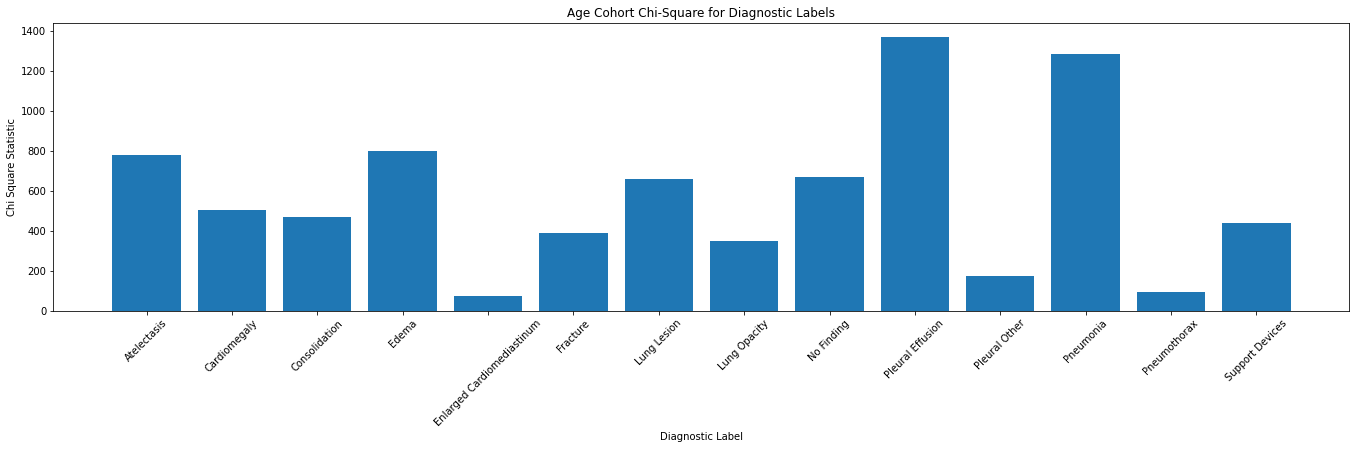

In [79]:
#remove labels that are not statistically significant
copy_dict = dict(chi_sq_age_dict)
for lab in chi_sq_dict:
    if copy_dict[lab][1] > 0.05: del copy_dict[lab]

#plot the rest
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
ax.bar([lab for lab in copy_dict], [copy_dict[lab][0] for lab in copy_dict])
plt.xticks(rotation=45)
plt.title("Age Cohort Chi-Square for Diagnostic Labels")
plt.ylabel("Chi Square Statistic")
plt.xlabel("Diagnostic Label")
plt.show()